# ExoMarsRSP SPICE Kernel Dataset Testcase 

This Jupyter Notebook is used to illustrate some examples on how to use the testcase provided in the ExoMarsRSP SKD.

The scenario that this release covers simulates a trip of the rover, the operation of the drill and an imaging observation by moving the payload bench on top of the mast by a given pan and tilt set of angles. 

Solution made by Bober S.A. stasbober@rlab.iki.rssi.ru

In [1]:
import spiceypy as spice, numpy as np, matplotlib.pyplot as plt
plt.rcParams.update({'font.size':16})
%matplotlib inline

Some functions to make life easier

In [2]:
def naif_window_2_array(cell):
    '''
    Convert spice window to numpy array
    :param cell: spice cell consists of time window information
    :type cell: spiceypy.stypes.SPICEDOUBLE_CELL
    
    '''
    return np.array([spice.wnfetd(cell, i) for i in range(spice.wncard(cell))])

In [3]:
# some corrections for Andrew Annex spiceypy function spkcov
def naif_spkcov(spk, idcode, cover=None):
    """
    Find the coverage window for a specified ephemeris object in a
    specified SPK file.
    http://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/spkcov_c.html
    :param spk: Name of SPK file.
    :type spk: str
    :param idcode: ID code of ephemeris object.
    :type idcode: int
    :param cover: Window giving coverage in "spk" for "idcode".
    :type cover: spiceypy.utils.support_types.SpiceCell
    """
    spk = spice.stypes.stringToCharP(spk)
    idcode = spice.ctypes.c_int(idcode)
    if not cover:
        cover = spice.stypes.SPICEDOUBLE_CELL(20000)
    assert isinstance(cover, spice.stypes.SpiceCell)
    assert cover.dtype == 1
    spice.libspice.spkcov_c(spk, idcode, spice.ctypes.byref(cover))
    return cover

In [4]:
import subprocess
def run_util(cmd, prnt=True):
    '''
    Run (console) program (utility) and return it output.
    :param cmd: command to run
    :type cmd: str or list of str 
    '''
    if type(cmd) == str:
        cmd = cmd.split()
    if prnt:
        print('Running:' , ' '.join(cmd))
    output = subprocess.Popen(cmd, stdout=subprocess.PIPE).communicate()[0].decode("utf-8")
    return output


In [6]:
# !!! don't forget to edit meta kernel, otherwise it woldn't be loaded !!!

spice.furnsh('kernels/mk/emrsp_rm_tlm_0001_v001.tm')

# Compute the distance and the altitude difference from the Landing Site to the Travel Site 001 (RM_SITE_001_001).

In [7]:
# check spk coverages
wnd = naif_spkcov('kernels/spk/emrsp_rm_ls-plan_v001.bsp', spice.bodn2c('RM_LANDING_SITE'))
LS_cov = naif_window_2_array(wnd).ravel()
spice.timout(LS_cov,
             'YYYY MON DD HR:MN:SC.####')

['2019 DEC 31 23:58:50.8160', '2099 DEC 31 23:58:50.8161']

In [8]:
# check spk coverages
wnd = naif_spkcov('kernels/spk/emrsp_rm_sites_v001.bsp', spice.bodn2c('RM_SITE_001_001'))
SITE_001_cov = naif_window_2_array(wnd).ravel()
spice.timout(SITE_001_cov,
             'YYYY MON DD HR:MN:SC.####')

['2018 DEC 31 23:58:50.8160', '2030 JAN 01 00:08:50.8160']

In [9]:
et = spice.str2et('2020 JAN 01 00:00:00.0000')

In [10]:
L = np.linalg.norm(spice.spkpos('RM_SITE_001_001', et, 'IAU_MARS', 'NONE', 'RM_LANDING_SITE')[0])
print('RM_SITE_001_001 to RM_LANDING_SITE distance', L, 'km')

RM_SITE_001_001 to RM_LANDING_SITE distance 2334.039987733189 km


# Generate a time interval that starts at the time that the Rover starts traveling and finishes when the Rover stops.

In [11]:
wnd = naif_spkcov('kernels/spk/emrsp_rm_gnc-tlm_0001_v001.bsp', spice.bodn2c('RM'))
rm_move_et = naif_window_2_array(wnd).ravel()
spice.timout(rm_move_et,
             'YYYY MON DD HR:MN:SC.####')

['2020 NOV 11 00:00:00.0000', '2020 NOV 11 00:06:15.0000']

# Compute the position of the Rover w.r.t the Travel Site 001 during the period that the rover is traveling, generate a 2-D plot of the travel path.

In [12]:
# 1000 time points, RM positions
et = np.linspace(*rm_move_et, 1000)
rm_path = np.array(spice.spkpos('RM', et, 'RM_MLG', 'NONE', 'RM_SITE_001_001')[0])

In [13]:
# time points every minute
et_minute = np.arange(*rm_move_et, 60)
rm_minute = np.array(spice.spkpos('RM', et_minute, 'RM_MLG', 'NONE', 'RM_SITE_001_001')[0])

Text(0, 0.5, '$Y, m$')

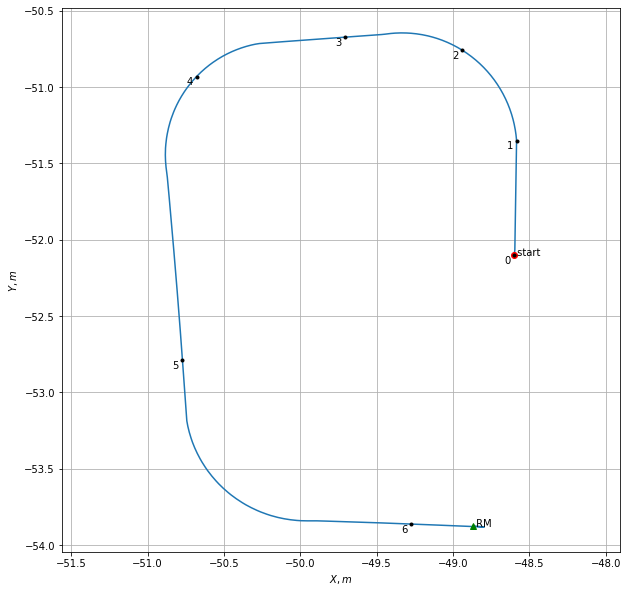

In [14]:
# rover path
xy = rm_path[:,:2]*1000 # scale to meters
xy_minute = rm_minute[:,:2]*1000

plt.figure(figsize=(10,10))
plt.plot(*xy.T)
plt.plot(*xy[0], 'or')
plt.text(*xy[0], ' start')
plt.plot(*xy[-1], '^g')
plt.text(*xy[-1], ' RM')
plt.plot(*xy_minute.T, '.k')
for i, p in enumerate(xy_minute):
    plt.text(*p, str(i)+' ', va='top', ha='right')
plt.axis('equal')
plt.grid()
plt.xlabel('$X, m$')
plt.ylabel('$Y, m$')

Text(0, 0.5, '$Z, m$')

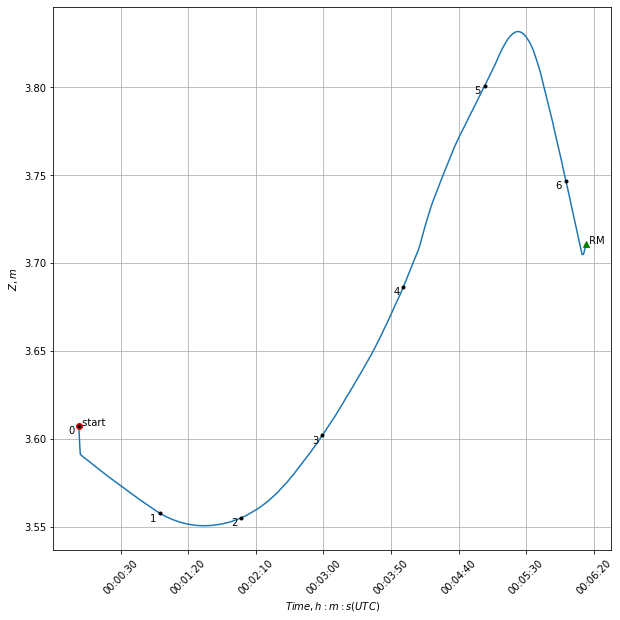

In [15]:
# vertical profile
tz = np.column_stack((et, rm_path[:,2]*1000))
tz_minute = np.column_stack((et_minute, rm_minute[:,2]*1000))

plt.figure(figsize=(10,10))
plt.plot(*tz.T)
plt.plot(*tz[0], 'or')
plt.text(*tz[0], ' start')
plt.plot(*tz[-1], '^g')
plt.text(*tz[-1], ' RM')
plt.plot(*tz_minute.T, '.k')
for i, p in enumerate(tz_minute):
    plt.text(*p, str(i)+' ', va='top', ha='right')
#plt.axis('equal')
plt.grid()
ax = plt.gca()
ax.set_xticklabels(spice.timout(ax.get_xticks(), 'HR:MN:SC'), rotation=45);
plt.xlabel('$Time, h:m:s (UTC)$')
plt.ylabel('$Z, m$')

# Compute the Angular Offset of the Rover +X axis (driving direction) w.r.t to the -X axis of the Mars Local Geodetic frame of the Travel Site 001. 

Let's compute rover driving direction each 10 seconds

In [16]:
et_10s = np.arange(*rm_move_et, 10)
rm_10s = np.array(spice.spkpos('RM', et_10s, 'RM_MLG', 'NONE', 'RM_SITE_001_001')[0])

# due to error in attitude of rover, use Z axis instead of X
axis = np.array([0., 0., 1.])
RM_dir = []
for e in et_10s:
    RM_dir.append(spice.pxform('RM_ROVER', 'RM_MLG', e)@axis)
RM_dir = np.array(RM_dir)

Text(0, 0.5, '$Y, m$')

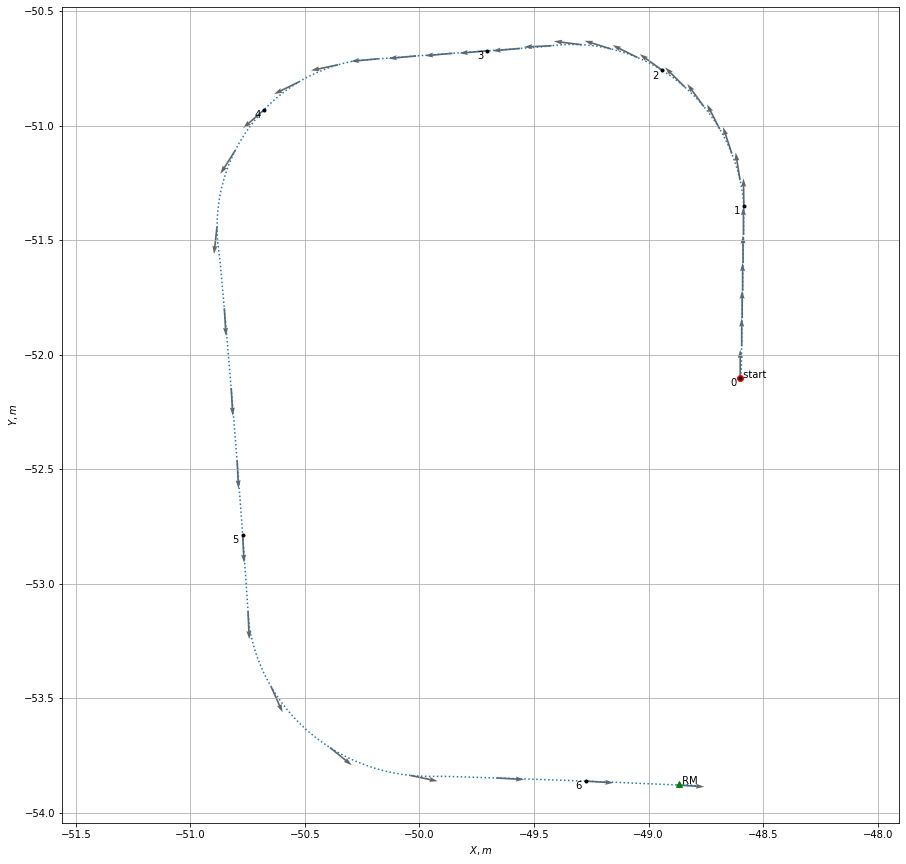

In [17]:
# rover path with driving direction
xy = rm_path[:,:2]*1000 # scale to meters
xy_minute = rm_minute[:,:2]*1000
xy_10s = rm_10s[:,:2]*1000
#dirs = RM_dir[:,:2]/np.linalg.norm(RM_dir[:,:2], axis=1, keepdims=True)
dirs = RM_dir[:,[0,2]]

plt.figure(figsize=(15,15))
plt.quiver(xy_10s[:,0], xy_10s[:,1], 
           dirs[:,0], dirs[:,1], 
           scale=30, alpha=0.6, width=0.002);
plt.plot(*xy.T, ':')
plt.plot(*xy[0], 'or')
plt.text(*xy[0], ' start')
plt.plot(*xy[-1], '^g')
plt.text(*xy[-1], ' RM')
plt.plot(*xy_minute.T, '.k')
for i, p in enumerate(xy_minute):
    plt.text(*p, str(i)+' ', va='top', ha='right')

plt.axis('equal')
plt.grid()
plt.xlabel('$X, m$')
plt.ylabel('$Y, m$')


Text(0, 0.5, 'Out of plane angle, $^\\circ$')

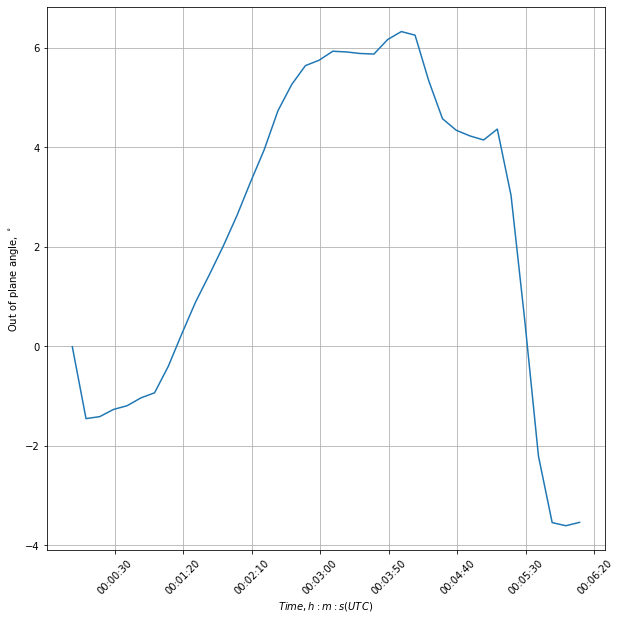

In [18]:
# out-of-plane angle

zangles = np.degrees(np.arctan2(RM_dir[:,1], (RM_dir[:,0]**2+RM_dir[:,2]**2)**0.5))
tz_10s = np.column_stack((et_10s, rm_10s[:,1]*1000))

tdir = np.column_stack((et_10s, zangles))

plt.figure(figsize=(10,10))
plt.plot(*tdir.T)
plt.grid()
ax = plt.gca()
ax.set_xticklabels(spice.timout(ax.get_xticks(), 'HR:MN:SC'), rotation=45);
plt.xlabel('$Time, h:m:s (UTC)$')
plt.ylabel('Out of plane angle, $^\circ$')

# Compute the position of the PanCam HRC sensor with respect to the RM center, are you finding any issue? Can you explain what is the problem?

In [19]:
# trying to compute -> fail
et = spice.str2et('2020 JAN 01 00:00:00.000')
spice.spkpos('RM_PANCAM_HRC', et, 'RM_ROVER', 'NONE', 'RM')

SpiceyError: 
================================================================================

Toolkit version: N0066

SPICE(SPKINSUFFDATA) --

Insufficient ephemeris data has been loaded to compute the position of -174130 (RM_PANCAM_HRC) relative to -174 (EXOMARS ROVER) at the ephemeris epoch 2020 JAN 01 00:01:09.183.

spkpos_c --> SPKPOS --> SPKEZP --> SPKGPS

================================================================================

In [20]:
# Look at emrsp_rm_v004.tf
# Below is frame chain as it should be
# ??? - is a real link in emrsp_rm_struct_v000.bsp kernel (see second cell below)

```
#           RM_PANCAM_HRC <-(fixed)- RM_PANCAM_BASE <-(fixed)- RM_PB <-(fixed)- RM_PTR[-174013]
#                                                                                 ^        ^
#                                                                             ____|        |
#                                                                            / ???        (ck)
#                                                                           /              |
# RM_ROVER[-174000] -(fixed)-> RM_MAST_ZERO[-174010] -(ck)-> RM_MAST[-174011] -(fixed)-> RM_PTR_ZERO[-174012] 
```

In [24]:
# 
print(run_util(['brief', '-c', 'kernels/mk/emrsp_rm_tlm_0001_v001.tm']))

Running: brief -c kernels/mk/emrsp_rm_tlm_0001_v001.tm
 
BRIEF -- Version 4.0.0, September 8, 2010 -- Toolkit Version N0066
 
 
Summary for: /Users/mcosta/ess_workshop_altec/lesson_exomarsrsp/kernels/spk/emrsp_rm_gnc-tlm_0001_v001.bsp
 
Body: EXOMARS ROVER (-174)* w.r.t. RM_SITE_001_001 (-174701001)
      Start of Interval (ET)              End of Interval (ET)
      -----------------------------       -----------------------------
      2020 NOV 11 00:01:09.182            2020 NOV 11 00:07:24.182
 
 
Summary for: /Users/mcosta/ess_workshop_altec/lesson_exomarsrsp/kernels/spk/emrsp_rm_interp-tlm_0001_v001.bsp
 
Body: EXOMARS ROVER (-174)* w.r.t. RM_SITE_001_001 (-174701001)
      Start of Interval (ET)              End of Interval (ET)
      -----------------------------       -----------------------------
      2020 NOV 11 00:01:09.182            2040 JAN 01 00:01:09.183
 
Body: RM_DRILL_POS_MOV (-174041)* w.r.t. RM_DRILL_POS_FIX (-174040)
      Start of Interval (ET)              End

# Generate a new SPK Travel Site, using the last position of the Rover and append it to the original Travel Site SPK

The solution is not complete

In [25]:
rm_path[-1]

array([-0.04886747, -0.05387457,  0.00371086])

In [26]:
s = r'''
\begindata
 SITES              = ( 'RM_SITE_002')

 RM_SITE_002_CENTER = 499
 RM_SITE_002_FRAME  = 'IAU_MARS'
 RM_SITE_002_IDCODE = <see fk emrsp_rm_v004.tf>
 RM_SITE_002_XYZ    = ( %f, %f, %f )
 RM_SITE_002_UP     = 'Z'
 RM_SITE_002_NORTH  = 'Y'
'''%(*rm_path[-1],)
print(s)


\begindata
 SITES              = ( 'RM_SITE_002')

 RM_SITE_002_CENTER = 499
 RM_SITE_002_FRAME  = 'IAU_MARS'
 RM_SITE_002_IDCODE = <see fk emrsp_rm_v004.tf>
 RM_SITE_002_XYZ    = ( -0.048867, -0.053875, 0.003711 )
 RM_SITE_002_UP     = 'Z'
 RM_SITE_002_NORTH  = 'Y'

